<a href="https://colab.research.google.com/github/julianox5/Aprendizado-Programacao-Curso-Machine-Learning-do-GoogleDevelopers/blob/master/06_Representa%C3%A7%C3%A3o_com_Cruzamento_de_Recursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Representação com cruzamento de recursos 
Neste exercício, vamos experimentar maneiras diferentes de representar recursos.



## Objetivo do Aprendizado com os Exercícios

Depois do exercícios, vamos saber: 
* Usar o Método [`tf.feature_column`] para representar os recurso de maneiras diferentes
* Representar recursos como `caixas` `(bins)`.
* Usar Caixas cruzadas para criar uma feature cross.


## O Conjunto de Dados
Como os exercícios anteriores, usaremos o conjunto de dados de habitação da Califórnia 

## Usando a versão correta do TensorFlow

In [0]:
%tensorflow_version 2.x

## Chamar as instruções de importação 
O código abaixo importa os módulos necessários para executar o código que vamos criar



In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers  

from matplotlib import pyplot as plt 

# as linhas a seguir ajustam a granularidade da notificação
pd.options.display.max_rows = 10 
pd.options.display.float_format ="{: 1f}".format

tf.keras.backend.set_floatx('float32')

print("módulos importados")


módulos importados


## Carregar, dimensionar e embaralhar os exemplos
O código a seguir carrega os arquivos .csv separados e cria dois DataFrames do Pandas: 
* `treina_df`, que contém os dados de treinamento
* `test_df`, que contém os dados de teste

A célula de código então dimensiona `median_house_value` para um intervalo mais amigável ao ser humano e, em seguida, apresenta os exemplos.

In [0]:
#Carregando os conjuntos de dados
treina_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df   = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

#Escalando os rótulos 
fator_escala = 1000.0

treina_df["median_house_value"] /= fator_escala 
test_df["median_house_value"] /= fator_escala

# Embaralhando os exemplos 
treina_df = treina_df.reindex(np.random.permutation(treina_df.index))

# Representar latitude e longitude como valores de ponto flutuante

Colabs anteriores treinados em apenas um único recurso ou um único recurso sintético. Por outro lado, este exercício se baseia em dois recursos. Além disso, este Colab apresenta colunas de recursos , que fornecem uma maneira sofisticada de representar recursos.

Você pode criar colunas de recursos como:
* Chame um método `tf.feature_column` para representar um único recurso, um único recurso cruzado ou um único recurso sintético da maneira desejada. Por exemplo, para representar um determinado recurso como valores de ponto flutuante, chame `tf.feature_column.numeric_column.` Para representar um determinado recurso como uma série de baldes ou caixas, ligue `tf.feature_column.bucketized_column`.
* Monte as representações criadas em uma lista Python.

A localização de um bairro é normalmente a característica mais importante na determinação do valor de uma casa. O conjunto de dados da California Housing fornece dois recursos `latitude` e `longitude` que identificam a localização de cada bairro.

Essa célula de código especifica os recursos nos quais você treinará o modelo e como cada um desses recursos será representado. As transformações (coletadas em `fp_camada_recurso`) não são realmente aplicadas até você passar um DataFrame para ele, o que acontecerá quando treinarmos o modelo.

In [0]:
#Criando uma lista vazia que conterá todas as colunas de recursos 
coluna_recursos = []

#Criando uma coluna de recurso numérico para representar a latitude
latitude = tf.feature_column.numeric_column("latitude")
coluna_recursos.append(latitude)

#Criando uma coluna de recurso numérico para representar a longitude como valor de ponto flutuante
longitude = tf.feature_column.numeric_column("longitude")
coluna_recursos.append(longitude)

#Convertendo a lista de coluna_recursos em uma camada que se tornará parte do modelo
fp_camada_recurso = layers.DenseFeatures(coluna_recursos)


Quando usada, a camada processa as entradas brutas, de acordo com as transformações descritas pelas colunas do recurso, e empacota o resultado em uma matriz numérica. (O modelo treinará nessa matriz numérica.)

## Definir funções que criam e treinam um modelo

Criando e compilando um simples modelo de regressão linear

In [0]:
def criar_modelo(tx_aprendizado, col_recursos):
  # A maiorias do modelos simples são sequencial
  modelo = tf.keras.models.Sequential()

  # Adicionando a camada que possui as colunas de recursos do modelo
  modelo.add(col_recursos)

  # Adicionando uma camada linear ao modelo para gerar uma regressão linear
  modelo.add(tf.keras.layers.Dense(units=1, input_shape = (1,)))

  # Contruindo as camadas em um modelo que o TensorFlow possa executar
  modelo.compile(optimizer=tf.keras.optimizers.RMSprop(lr=tx_aprendizado),
                 loss="mean_squared_error",
                 metrics=[tf.keras.metrics.RootMeanSquaredError()])
  
  return modelo

## Criando a função para treinar o modelo

In [0]:
def treinar_modelo(modelo, set_dados, epochs, tam_lote, nome_rotulo):
  """ Alimente um conjunto de dados ao modelo para treina-lo"""

  recursos = {name:np.array(value) for name, value in set_dados.items()}

  rotulo   = np.array(recursos.pop(nome_rotulo))

  history  = modelo.fit(x=recursos, y=rotulo, batch_size=tam_lote,
                       epochs=epochs, shuffle=True)

  #A lista de épocas é armazenada separadamente do resto do history
  epochs = history.epoch

  #Isole o erro médio absoluto  para cada época.
  hist = pd.DataFrame(history.history)
  rmse = hist["root_mean_squared_error"]

  return epochs, rmse 

#Criando função para plotar uma curva de perda


In [13]:
def plot_curva_perda(epochs, rmse):

  plt.figure()
  plt.xlabel("Epocas")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()*1.05]) 
  plt.show

print("Função de plotagem definida!")

Função de plotagem definida!


## Treinar o modelo com representações de ponto flutuante
A célula de código a seguir chama as funções que você acabou de criar para treinar, plotar e avaliar um modelo.

Epoch 1/30
170/170 [==============================] - 0s 1ms/step - loss: 17057.3789 - root_mean_squared_error: 130.6039
Epoch 2/30
170/170 [==============================] - 0s 1ms/step - loss: 13457.8418 - root_mean_squared_error: 116.0079
Epoch 3/30
170/170 [==============================] - 0s 1ms/step - loss: 13425.4814 - root_mean_squared_error: 115.8684
Epoch 4/30
170/170 [==============================] - 0s 1ms/step - loss: 13363.0146 - root_mean_squared_error: 115.5985
Epoch 5/30
170/170 [==============================] - 0s 1ms/step - loss: 13322.2461 - root_mean_squared_error: 115.4220
Epoch 6/30
170/170 [==============================] - 0s 1ms/step - loss: 13280.6377 - root_mean_squared_error: 115.2416
Epoch 7/30
170/170 [==============================] - 0s 1ms/step - loss: 13232.8477 - root_mean_squared_error: 115.0341
Epoch 8/30
170/170 [==============================] - 0s 1ms/step - loss: 13207.4189 - root_mean_squared_error: 114.9235
Epoch 9/30
170/170 [============

[12166.8037109375, 110.30323791503906]

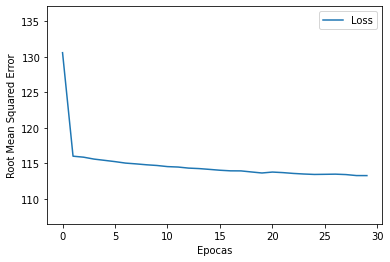

In [16]:
taxa_aprendizado = 0.05 
epochs = 30 
tam_lote = 100
nome_label = "median_house_value"

# Criar e compilar a topografia do modelo
meu_modelo = criar_modelo(taxa_aprendizado, fp_camada_recurso)

# Treinar o modelo no conjunto de treinamento
epochs, rmse = treinar_modelo(meu_modelo, treina_df, epochs, tam_lote, nome_label)

# gráfico curva de perda
plot_curva_perda(epochs, rmse)

print("\n Avaliar o novo model em relação ao conjunto de teste: ")
teste_recursos = {name:np.array(value) for name, value in test_df.items()}
teste_rotulo   = np.array(teste_recursos.pop(nome_label))
meu_modelo.evaluate(x=teste_recursos, y=teste_rotulo, batch_size=tam_lote)